In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import scipy.stats as stats

from utils.data_utils import toNumeric, coverage_ratio
from utils.plot_utils import plot_histograms

# XGBoost synopsis: what is it, how to use it.

## Learning Goals
We go through a simple example to get acquainted with XGBoost. The learning goals are:
1. understand the basic concepts behind XGBoost operation.
2. Setup XGBoost with and without a random search optimization 

### The Dataset
The UCI Heart Disease dataset contains biological measurements performed on individuals which may or may not have hearth disease. The target variable `num` is *binary* and represents the angiographic disease status. The variables in the feature matrix are
1. age
2. sex
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbpd: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl  (1 = true; 0 = false)
7. restecg:  resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
8. thalach: maximum heart rate achieved                  
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flouroscopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

14. num: diagnosis of heart disease (angiographic disease status) **target**

In [46]:
df = pd.read_csv('heart_disease.csv').drop('Unnamed: 0', axis=1)

In [47]:
df.head()

,age,sex,cp,trestbpd,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


Let's examine the missing value situation

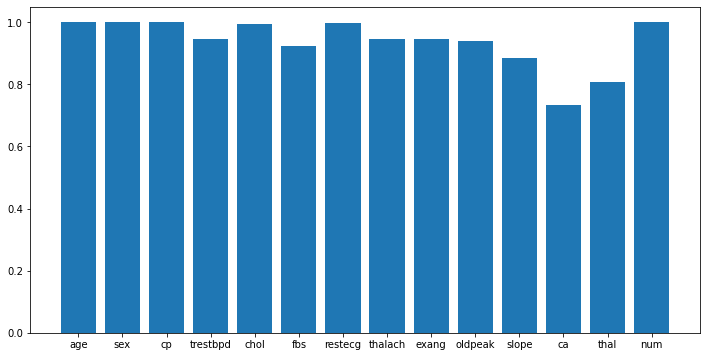

{'age': 1.0,
 'sex': 1.0,
 'cp': 1.0,
 'trestbpd': 0.9472817133443163,
 'chol': 0.9950576606260296,
 'fbs': 0.9242174629324547,
 'restecg': 0.9983525535420099,
 'thalach': 0.9472817133443163,
 'exang': 0.9472817133443163,
 'oldpeak': 0.9406919275123559,
 'slope': 0.8846787479406919,
 'ca': 0.7331136738056013,
 'thal': 0.8072487644151565,
 'num': 1.0}

In [48]:
coverage_ratio(df, plot=True)

almost 100% for all variables, inputation would not be too aggressive.

### A bit of data cleaning and imputation

In [70]:
# fasting blood sugar
df = df[df.fbs >= 0]

# we can do some imputation, we have a low number of missing values
inputed_vars = ['thal', 'fbs', 'slope', 'oldpeak', 'exang', 'thalach', 'trestbpd', 'ca']
for var in inputed_vars:
    cond = (df[var] < 0) | (df[var].isna())
    df.loc[cond, var] = df[~cond][var].median()

# remove also the zero value for cholesterol
var = 'chol'
cond = (df[var] <= 0) | (df[var].isna())
df.loc[cond, var] = df[~cond][var].median()

### Extra: interactions an chi-square test

There are many legitimate questions we may ask. For example we could examine the [interactions](https://en.wikipedia.org/wiki/Interaction_(statistics)) between effects. But that would take us away from our goals. Let's do a quick *chi-squared* test instead. Are people with a high blood sugar more at risk of disease? The 

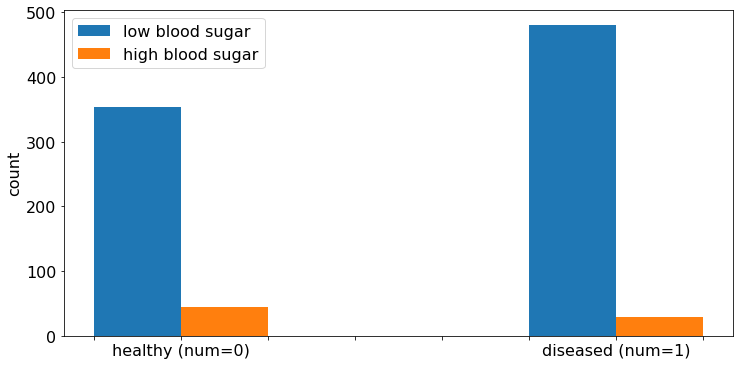

In [64]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar([-.1, .9], [len(df[(df.fbs==0) & (df.num == 0)].num), len(df[df.fbs==0 & (df.num == 1)].num)], width=.2, label="low blood sugar");
ax.bar([0.1, 1.1], [len(df[(df.fbs==1)  & (df.num == 0)].num), len(df[(df.fbs==1)  & (df.num == 1)].num)], width=.2, label="high blood sugar");
ax.set_xticklabels(["", "", "healthy (num=0)", "", "", "", "", "diseased (num=1)", ""], fontsize=16)
plt.ylabel("count", fontsize=16)
ax.tick_params('y', labelsize=16)
plt.legend(fontsize=16);

In [66]:
ctable = pd.crosstab(df.fbs, df.num)
ctable

num,0,1
fbs,,
0.0,353,127
1.0,44,29


In [68]:
chi2, p, _, _ = stats.chi2_contingency(ctable.values)
print("stat = {}, pval = {}".format(chi2, p))

stat = 4.87198076495907, pval = 0.027296152275288182


No significant correlation at 5% significance level. We would also like to know what is the power of the test but let's move on the XGBoost.

Let's check the outliers situation and get an idea of how the data are distributed for the two types of patients

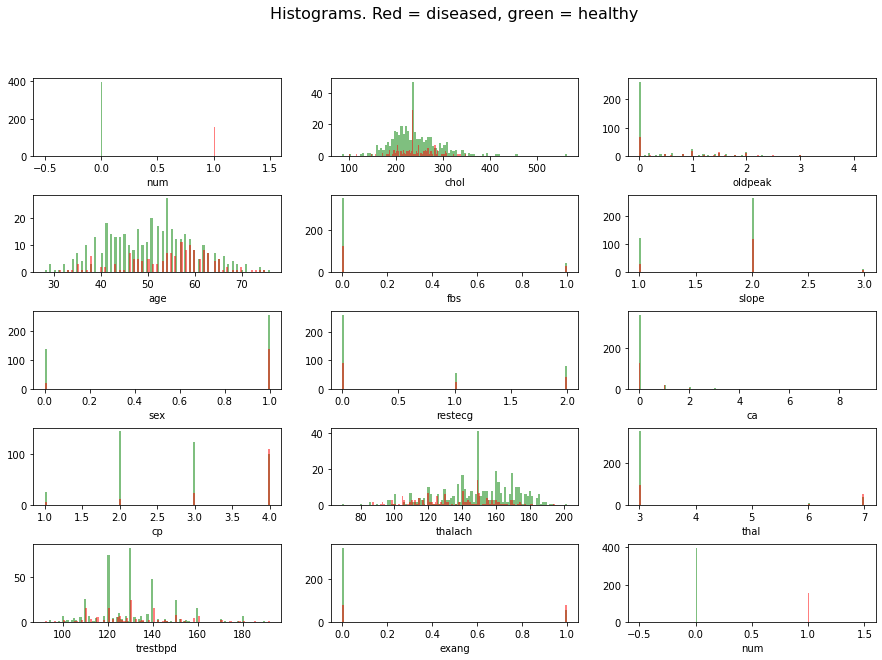

In [71]:
plot_histograms(df)

no significant outliers and no strong separation between the histograms of the two types of patients

## XGBoost Setup